# Block Move in Fixed Time

Here, we look at a problem called "Block Move". Block Move is a very simple optimal control problem defined by Matthew Kelly in the paper *[An Introduction to Trajectory Optimization: How to Do Your Own Direct Collocation](https://epubs.siam.org/doi/10.1137/16M1062569)*.

The basics of the problem are this:

-----

Suppose we have a block with a unit mass on a frictionless surface; the block can slide forward and backwards along a number line $x$. At $t=0$, the block starts at $x=0$ with velocity $v=0$. At $t=1$, we want the block to have moved to $x=1$ and again be stationary with $v=0$.

We are allowed to apply any amount of force $u(t)$ to the block, but we want to find the path that minimizes the amount of "effort" applied. We measure "effort" as the integral $\int_0^1 u(t)^2\ dt$.

What should our force input $u(t)$ be?

-----

Let's solve the problem. First, we do some boilerplate setup:

In [8]:
import aerosandbox as asb
import aerosandbox.numpy as np

opti = asb.Opti()

n_timesteps = 300
mass_block = 1

Then, we define our time vector, our state vectors, and our force vector.

In [9]:
time = np.linspace(0, 1, n_timesteps)

position = opti.variable(
    init_guess=np.linspace(0, 1, n_timesteps) # Guess a trajectory that takes us there linearly.
)

velocity = opti.derivative_of(
    position,
    with_respect_to=time,
    derivative_init_guess=1, # Guess a velocity profile that is uniform over time.
)

force = opti.variable(
    init_guess=np.linspace(1, -1, n_timesteps), # Guess that the force u(t) goes from 1 to -1 over the time window.
    n_vars=n_timesteps
)

We can't forget to constrain the derivative of velocity to be equal to the acceleration!

In [10]:
opti.constrain_derivative(
    variable=velocity,
    with_respect_to=time,
    derivative=force / mass_block, # F = ma
)

Now, we compute the amount of effort expended using a numerical integral:

In [11]:
effort_expended = np.sum(
    np.trapz(force ** 2) * np.diff(time)
)

opti.minimize(effort_expended)

Can't forget to add those boundary conditions!

Some notes:
* *"Wait, isn't $x=0$ an initial condition, not a boundary condition?"* There is no mathematical difference between *initial conditions* and *boundary conditions*. We use the phrase "boundary conditions" to refer to both. This helps eliminate any confusion between "initial conditions" and "initial guesses".

* *"Wait, what's the difference between initial conditions and initial guesses?"* "Initial conditions" are really just boundary conditions that happen to be applied at the boundary $t=0$. "Initial guesses" are our best guess for each of our design variables - basically, our best guess for the optimal trajectory. It is so important that the distinction be understood! Again, we use the "boundary conditions" catch-all rather than "initial conditions" to help reinforce this distinction.

Now for those boundary conditions:

In [12]:
opti.subject_to([
    position[0] == 0,
    position[-1] == 1,
    velocity[0] == 0,
    velocity[-1] == 0,
])

[MX(fabs(opti1_lam_g_3)),
 MX(fabs(opti1_lam_g_4)),
 MX(fabs(opti1_lam_g_5)),
 MX(fabs(opti1_lam_g_6))]

Now, we solve.

In [13]:
sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2396
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      300

Total number of variables............................:      900
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      602
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3334079e-01 1.00e+00 5.58e-06   0.0 0.00e+00    -  0.00e+00 0.00e+00  

This actually solves in just one iteration because it is an unconstrained quadratic program.

Let's plot what our solution looks like:

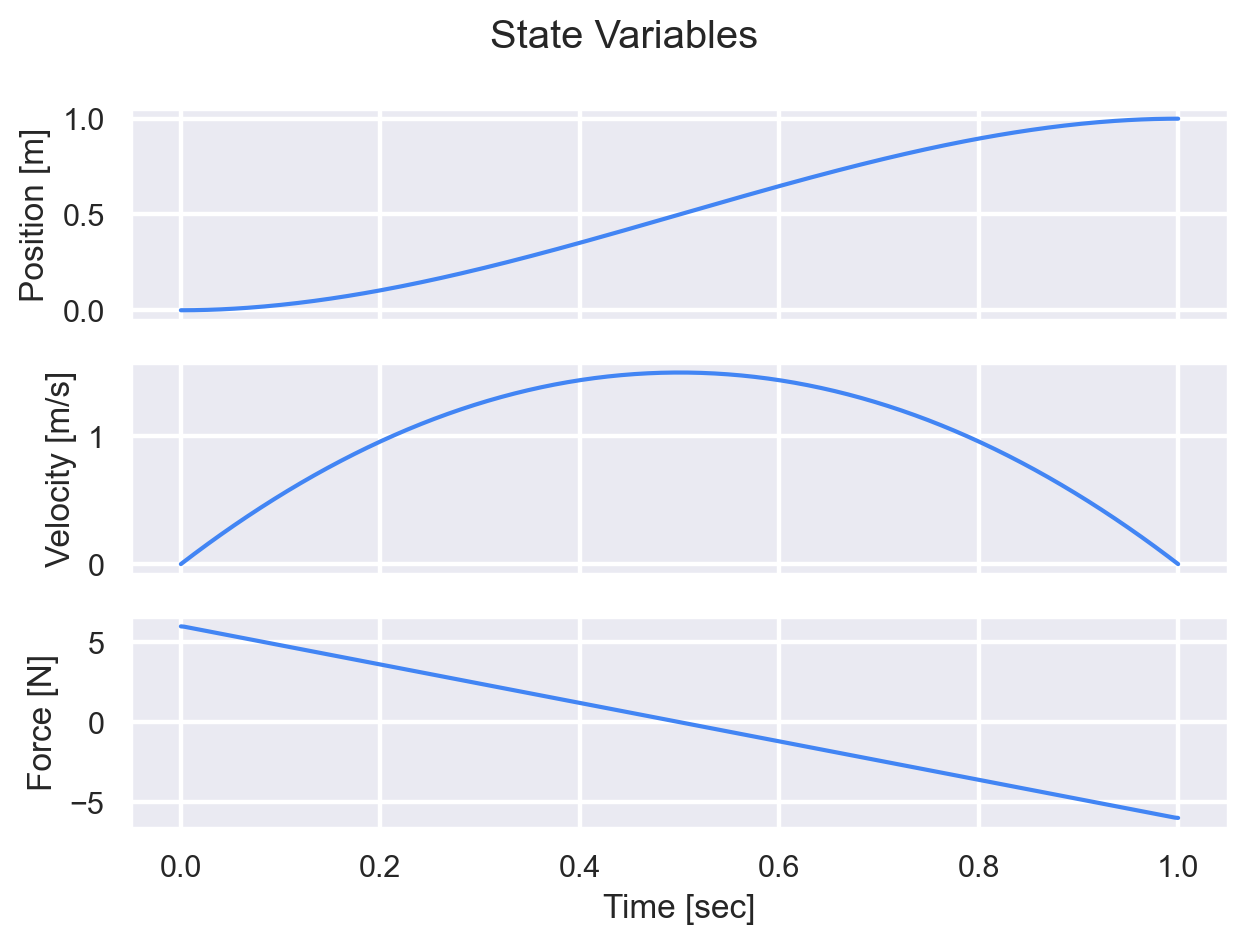

In [14]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(3, sharex=True)
for a, (name, var) in zip(ax, {
    "Position [m]"  : position,
    "Velocity [m/s]": velocity,
    "Force [N]"     : force,
}.items()):
    a.plot(sol.value(time), sol.value(var))
    a.set_ylabel(name)
p.show_plot("State Variables", "Time [sec]")

That makes sense! We can actually prove optimality of these functions here using calculus of variations; see Appendix B of the Kelly paper for more details.